[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [1]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [4]:
!nvidia-smi

Wed Mar 19 13:28:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [27]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [2]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-03-19 13:27:39--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-03-19 13:27:39 (75.3 MB/s) - ‘dog.jpeg’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

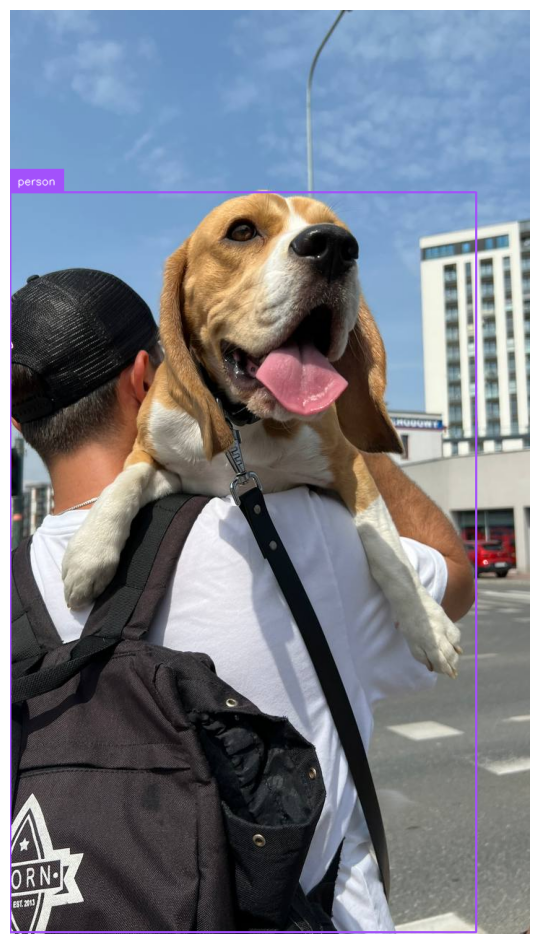

In [28]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/dog.jpeg"
image = cv2.imread(image_path)

model = YOLO('yolov12s.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [16]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="yYf0oFRqVThzJtqnC6D4")
project = rf.workspace("rieworks").project("splashsafe-anti-drowning-system")
version = project.version(4)
dataset = version.download("yolov12")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to SplashSafe:-Anti-Drowning-System-4 in yolov12:: 100%|██████████| 29958/29958 [00:07<00:00, 3753.12it/s]


In [17]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [18]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [19]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 3
names: ['drowning', 'out of water', 'swimming']

roboflow:
  workspace: rieworks
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=100)

New https://pypi.org/project/ultralytics/8.3.89 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/SplashSafe:-Anti-Drowning-System-2/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embe

train: Scanning /content/SplashSafe:-Anti-Drowning-System-2/train/labels.cache... 2632 images, 177 backgrounds, 0 corrupt: 100%|██████████| 2632/2632 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/SplashSafe:-Anti-Drowning-System-2/valid/labels.cache... 108 images, 3 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      6.77G      3.102      3.975      4.014         20        640: 100%|██████████| 165/165 [01:33<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

                   all        108        110    0.00409       0.85     0.0124    0.00439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.12G      2.517      3.443      3.106         16        640: 100%|██████████| 165/165 [01:29<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]

                   all        108        110     0.0027      0.528      0.015     0.0053



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.15G      2.222      3.209      2.713         13        640: 100%|██████████| 165/165 [01:28<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

                   all        108        110      0.525     0.0196     0.0264    0.00879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.15G      2.082      3.143      2.558         22        640: 100%|██████████| 165/165 [01:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.29it/s]

                   all        108        110     0.0034     0.0147     0.0016   0.000617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.11G      1.973      3.108      2.426         19        640: 100%|██████████| 165/165 [01:27<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]

                   all        108        110    0.00186       0.49     0.0533     0.0191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      7.14G      1.835      3.029        2.3         16        640: 100%|██████████| 165/165 [01:27<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]

                   all        108        110    0.00347      0.688     0.0414     0.0168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.98G      1.709      2.971      2.198         14        640: 100%|██████████| 165/165 [01:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

                   all        108        110      0.549      0.186     0.0469     0.0161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.98G      1.657      2.955      2.134         13        640: 100%|██████████| 165/165 [01:29<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

                   all        108        110      0.509      0.456      0.101     0.0463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.11G      1.564      2.851      2.059         23        640: 100%|██████████| 165/165 [01:29<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

                   all        108        110      0.631       0.23      0.125     0.0508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.97G      1.554      2.803      2.033         15        640: 100%|██████████| 165/165 [01:29<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

                   all        108        110      0.652     0.0735      0.113     0.0585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.98G      1.525      2.729      2.009         17        640: 100%|██████████| 165/165 [01:29<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

                   all        108        110      0.745      0.216      0.252      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.98G      1.498      2.668      1.991         15        640: 100%|██████████| 165/165 [01:36<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        108        110      0.799      0.265      0.279      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.11G      1.483      2.571      1.971         24        640: 100%|██████████| 165/165 [01:30<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        108        110      0.779      0.235      0.244       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.98G      1.483      2.545      1.959         15        640: 100%|██████████| 165/165 [01:30<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]

                   all        108        110      0.711      0.245      0.214      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      6.98G      1.454      2.509      1.924         17        640: 100%|██████████| 165/165 [01:29<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

                   all        108        110      0.781      0.265       0.29      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.98G      1.441      2.512      1.934         19        640: 100%|██████████| 165/165 [01:29<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

                   all        108        110      0.791      0.292      0.306      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.11G      1.418      2.431      1.905         18        640: 100%|██████████| 165/165 [01:29<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        108        110      0.778      0.233      0.265      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.97G      1.399      2.407      1.894         17        640: 100%|██████████| 165/165 [01:29<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

                   all        108        110       0.84       0.26      0.303      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.98G      1.396      2.416      1.886         20        640: 100%|██████████| 165/165 [01:29<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        108        110       0.89      0.259      0.328      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      6.98G      1.395      2.362      1.872         14        640: 100%|██████████| 165/165 [01:29<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all        108        110      0.916      0.304      0.374       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.11G      1.379      2.376      1.881         22        640: 100%|██████████| 165/165 [01:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

                   all        108        110      0.831      0.268      0.328      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.97G      1.373      2.358      1.859         16        640: 100%|██████████| 165/165 [01:29<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

                   all        108        110      0.787       0.27      0.277      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.98G      1.361      2.307      1.845         16        640: 100%|██████████| 165/165 [01:30<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all        108        110      0.855      0.299      0.346      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      6.98G      1.349      2.327      1.849         15        640: 100%|██████████| 165/165 [01:30<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

                   all        108        110      0.843      0.279      0.339      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.11G      1.323      2.291      1.835         12        640: 100%|██████████| 165/165 [01:29<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        108        110       0.91      0.319      0.383      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.14G      1.343        2.3      1.838         10        640: 100%|██████████| 165/165 [01:29<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

                   all        108        110      0.869      0.284      0.341      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      6.98G      1.336      2.278      1.822         16        640: 100%|██████████| 165/165 [01:29<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

                   all        108        110      0.873      0.294      0.341      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      6.98G      1.324      2.256      1.822         17        640: 100%|██████████| 165/165 [01:29<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]

                   all        108        110      0.819       0.25      0.292      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.11G      1.343      2.301      1.827         14        640: 100%|██████████| 165/165 [01:29<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

                   all        108        110      0.879      0.354      0.401      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.14G      1.313       2.26      1.811         21        640: 100%|██████████| 165/165 [01:29<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

                   all        108        110      0.865      0.314      0.392      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.98G      1.331      2.262      1.817         18        640: 100%|██████████| 165/165 [01:29<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]

                   all        108        110      0.871       0.26      0.341      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.98G      1.293      2.212      1.803         13        640: 100%|██████████| 165/165 [01:29<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]

                   all        108        110      0.907      0.324      0.389      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.11G      1.315      2.239      1.812         15        640: 100%|██████████| 165/165 [01:29<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

                   all        108        110      0.859      0.314      0.361      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.97G      1.294      2.214       1.79         13        640: 100%|██████████| 165/165 [01:29<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]

                   all        108        110      0.883      0.328      0.379      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.98G      1.291      2.196      1.793         13        640: 100%|██████████| 165/165 [01:29<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

                   all        108        110      0.866       0.32      0.405      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      6.98G      1.291      2.176      1.793         12        640: 100%|██████████| 165/165 [01:29<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]

                   all        108        110      0.822      0.292      0.327      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      7.11G      1.298      2.241      1.806         15        640: 100%|██████████| 165/165 [01:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]

                   all        108        110      0.928      0.314      0.403      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      7.14G      1.296      2.222      1.784         17        640: 100%|██████████| 165/165 [01:28<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]

                   all        108        110      0.845      0.329      0.357      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      6.98G      1.288      2.195      1.777         12        640: 100%|██████████| 165/165 [01:29<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]

                   all        108        110      0.889      0.348        0.4      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.98G      1.298      2.243      1.799         19        640: 100%|██████████| 165/165 [01:29<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]

                   all        108        110      0.889      0.275      0.356      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.11G      1.281       2.17      1.777         19        640: 100%|██████████| 165/165 [01:29<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

                   all        108        110      0.937      0.328      0.461      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.97G      1.256      2.165      1.766         12        640: 100%|██████████| 165/165 [01:29<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

                   all        108        110      0.955      0.296      0.394      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.98G      1.256      2.142      1.768         15        640: 100%|██████████| 165/165 [01:29<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]

                   all        108        110      0.889      0.325      0.411      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.98G      1.249      2.143      1.765         16        640: 100%|██████████| 165/165 [01:29<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]

                   all        108        110      0.939      0.319       0.42      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      7.11G      1.258      2.131       1.76         15        640: 100%|██████████| 165/165 [01:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

                   all        108        110      0.865      0.292      0.376      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.14G      1.265      2.152      1.764         18        640: 100%|██████████| 165/165 [01:29<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all        108        110      0.888      0.304      0.432      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.98G      1.247      2.154      1.753         18        640: 100%|██████████| 165/165 [01:28<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        108        110       0.92      0.284      0.452      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      6.98G      1.238      2.135      1.748         16        640: 100%|██████████| 165/165 [01:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]

                   all        108        110      0.885      0.343      0.425      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      7.11G      1.247      2.106      1.761         14        640: 100%|██████████| 165/165 [01:29<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.53it/s]

                   all        108        110      0.486       0.43      0.467      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.98G      1.227      2.045      1.735         16        640: 100%|██████████| 165/165 [01:29<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

                   all        108        110      0.914      0.328      0.463      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      7.15G      1.227      2.088      1.736         14        640: 100%|██████████| 165/165 [01:29<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]

                   all        108        110      0.348       0.44      0.456      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.98G      1.232      2.094      1.737         21        640: 100%|██████████| 165/165 [01:29<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]

                   all        108        110      0.925      0.306      0.409      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      7.11G      1.217      2.061      1.732         12        640: 100%|██████████| 165/165 [01:29<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]

                   all        108        110      0.915      0.324      0.427      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.97G      1.219      2.039      1.733         15        640: 100%|██████████| 165/165 [01:29<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]

                   all        108        110      0.928      0.333      0.429      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.98G      1.226      2.093      1.735         18        640: 100%|██████████| 165/165 [01:28<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]

                   all        108        110      0.893      0.324      0.464      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      7.15G      1.213      2.074      1.725         15        640: 100%|██████████| 165/165 [01:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]

                   all        108        110      0.919      0.328      0.438      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      7.11G      1.207      2.054      1.729         15        640: 100%|██████████| 165/165 [01:29<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

                   all        108        110      0.951      0.309      0.443      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      6.98G      1.211      2.073      1.727         13        640: 100%|██████████| 165/165 [01:28<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

                   all        108        110      0.932      0.343      0.455      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.98G      1.218      2.048       1.73         16        640: 100%|██████████| 165/165 [01:28<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]

                   all        108        110      0.914      0.324      0.433      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      7.15G      1.217      2.044      1.735         16        640: 100%|██████████| 165/165 [01:29<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

                   all        108        110      0.444       0.49      0.466      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.11G      1.188      2.007      1.712         16        640: 100%|██████████| 165/165 [01:29<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

                   all        108        110      0.932      0.345      0.444      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      6.97G      1.206      2.016      1.725         19        640: 100%|██████████| 165/165 [01:29<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

                   all        108        110       0.94      0.321      0.429      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.15G      1.201       2.01      1.721         13        640: 100%|██████████| 165/165 [01:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

                   all        108        110      0.913      0.349      0.444      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      7.15G      1.208      2.006      1.715         15        640: 100%|██████████| 165/165 [01:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]

                   all        108        110      0.892      0.363      0.441      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      7.11G      1.205      2.018      1.728         19        640: 100%|██████████| 165/165 [01:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all        108        110      0.924      0.328      0.426      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.97G      1.197      2.002      1.718         16        640: 100%|██████████| 165/165 [01:29<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]

                   all        108        110      0.941      0.348      0.444      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      7.15G      1.177      1.976      1.705         12        640: 100%|██████████| 165/165 [01:29<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

                   all        108        110       0.93      0.338      0.441      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      7.15G      1.193      1.973      1.711         16        640: 100%|██████████| 165/165 [01:29<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        108        110      0.412      0.478      0.456      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      7.11G      1.176      1.948      1.699         13        640: 100%|██████████| 165/165 [01:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

                   all        108        110      0.373      0.435      0.449      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.97G      1.172       1.94       1.68         15        640: 100%|██████████| 165/165 [01:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]

                   all        108        110      0.927      0.333      0.425      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      7.15G      1.189      1.943      1.711         18        640: 100%|██████████| 165/165 [01:28<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]

                   all        108        110      0.589      0.396      0.445      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      7.15G      1.157      1.967      1.689         19        640: 100%|██████████| 165/165 [01:28<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]

                   all        108        110      0.367      0.366      0.424      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      7.11G      1.174      1.962      1.698         16        640: 100%|██████████| 165/165 [01:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]

                   all        108        110       0.38      0.451      0.452      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.97G      1.171      1.948      1.693         16        640: 100%|██████████| 165/165 [01:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]

                   all        108        110      0.428      0.401      0.441       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      6.98G      1.162      1.939      1.689         12        640: 100%|██████████| 165/165 [01:29<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]

                   all        108        110      0.391       0.46      0.463      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      7.15G      1.157      1.905      1.691         11        640: 100%|██████████| 165/165 [01:29<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]

                   all        108        110      0.397      0.373       0.46      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      7.11G      1.157      1.904      1.696         13        640: 100%|██████████| 165/165 [01:29<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]

                   all        108        110      0.374      0.527      0.481      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.98G      1.149      1.939      1.673         14        640: 100%|██████████| 165/165 [01:29<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

                   all        108        110      0.411      0.588      0.474      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.98G      1.155      1.892      1.687         17        640: 100%|██████████| 165/165 [01:29<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]

                   all        108        110      0.954      0.324      0.452      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      7.15G      1.169      1.912      1.693         14        640: 100%|██████████| 165/165 [01:29<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]

                   all        108        110      0.403      0.455      0.463      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      7.11G      1.154      1.908       1.68         13        640: 100%|██████████| 165/165 [01:29<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

                   all        108        110      0.431      0.366      0.448      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      6.97G       1.15      1.876      1.677         20        640: 100%|██████████| 165/165 [01:29<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

                   all        108        110       0.44      0.373      0.471      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      6.98G      1.154       1.89      1.674         17        640: 100%|██████████| 165/165 [01:29<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

                   all        108        110      0.352      0.537      0.473      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      6.98G      1.148      1.913      1.683         19        640: 100%|██████████| 165/165 [01:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]

                   all        108        110      0.487      0.425      0.474      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      7.11G      1.141      1.865      1.672         19        640: 100%|██████████| 165/165 [01:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]

                   all        108        110      0.412      0.464       0.46      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.97G      1.148      1.887      1.678         18        640: 100%|██████████| 165/165 [01:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]

                   all        108        110      0.376      0.604      0.472      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.98G      1.143      1.872      1.671         14        640: 100%|██████████| 165/165 [01:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]

                   all        108        110      0.431      0.599      0.478      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.98G      1.122      1.858      1.657         15        640: 100%|██████████| 165/165 [01:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]

                   all        108        110      0.364      0.599      0.468      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      7.11G      1.135      1.846      1.662         16        640: 100%|██████████| 165/165 [01:28<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]

                   all        108        110      0.371      0.424      0.454      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.97G      1.139      1.866      1.668         20        640: 100%|██████████| 165/165 [01:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]

                   all        108        110      0.434      0.343       0.45      0.238


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.98G      1.341      1.971      1.838          7        640: 100%|██████████| 165/165 [01:29<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]

                   all        108        110      0.412      0.368      0.464      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.98G      1.309       1.87      1.812          9        640: 100%|██████████| 165/165 [01:27<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]

                   all        108        110      0.437       0.46      0.462      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      7.11G      1.292      1.831      1.791          7        640: 100%|██████████| 165/165 [01:27<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]

                   all        108        110      0.409      0.445       0.45       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.97G      1.294      1.804      1.798          8        640: 100%|██████████| 165/165 [01:27<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]

                   all        108        110      0.374       0.46      0.464      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.98G      1.287      1.797      1.796          9        640: 100%|██████████| 165/165 [01:27<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]

                   all        108        110      0.425      0.343      0.444      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      6.98G      1.281      1.785      1.789          6        640: 100%|██████████| 165/165 [01:28<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]

                   all        108        110      0.448      0.425       0.45      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      7.11G      1.281      1.755      1.794          7        640: 100%|██████████| 165/165 [01:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]

                   all        108        110      0.447      0.445      0.446      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.97G      1.284      1.749      1.797          8        640: 100%|██████████| 165/165 [01:28<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        108        110      0.426      0.338      0.437      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      6.98G      1.264      1.725      1.782          8        640: 100%|██████████| 165/165 [01:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]

                   all        108        110      0.452      0.348      0.447      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      7.15G      1.269      1.741       1.79          8        640: 100%|██████████| 165/165 [01:28<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]

                   all        108        110      0.442      0.333      0.448      0.238



100 epochs completed in 2.555 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 18.6MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,074,982 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


                   all        108        110      0.487      0.425      0.474      0.244
              drowning        102        102       0.81      0.725      0.822      0.458
              swimming          7          8      0.164      0.125      0.127     0.0311
Speed: 0.3ms preprocess, 9.4ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/detect/train3


## Evaluate fine-tuned YOLOv12 model

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train3/

args.yaml					   R_curve.png		 val_batch0_labels.jpg
confusion_matrix_normalized.png			   results.csv		 val_batch0_pred.jpg
confusion_matrix.png				   results.png		 val_batch1_labels.jpg
events.out.tfevents.1741952441.d1a0b42500be.429.1  train_batch0.jpg	 val_batch1_pred.jpg
F1_curve.png					   train_batch14850.jpg  val_batch2_labels.jpg
labels_correlogram.jpg				   train_batch14851.jpg  val_batch2_pred.jpg
labels.jpg					   train_batch14852.jpg  weights
P_curve.png					   train_batch1.jpg
PR_curve.png					   train_batch2.jpg


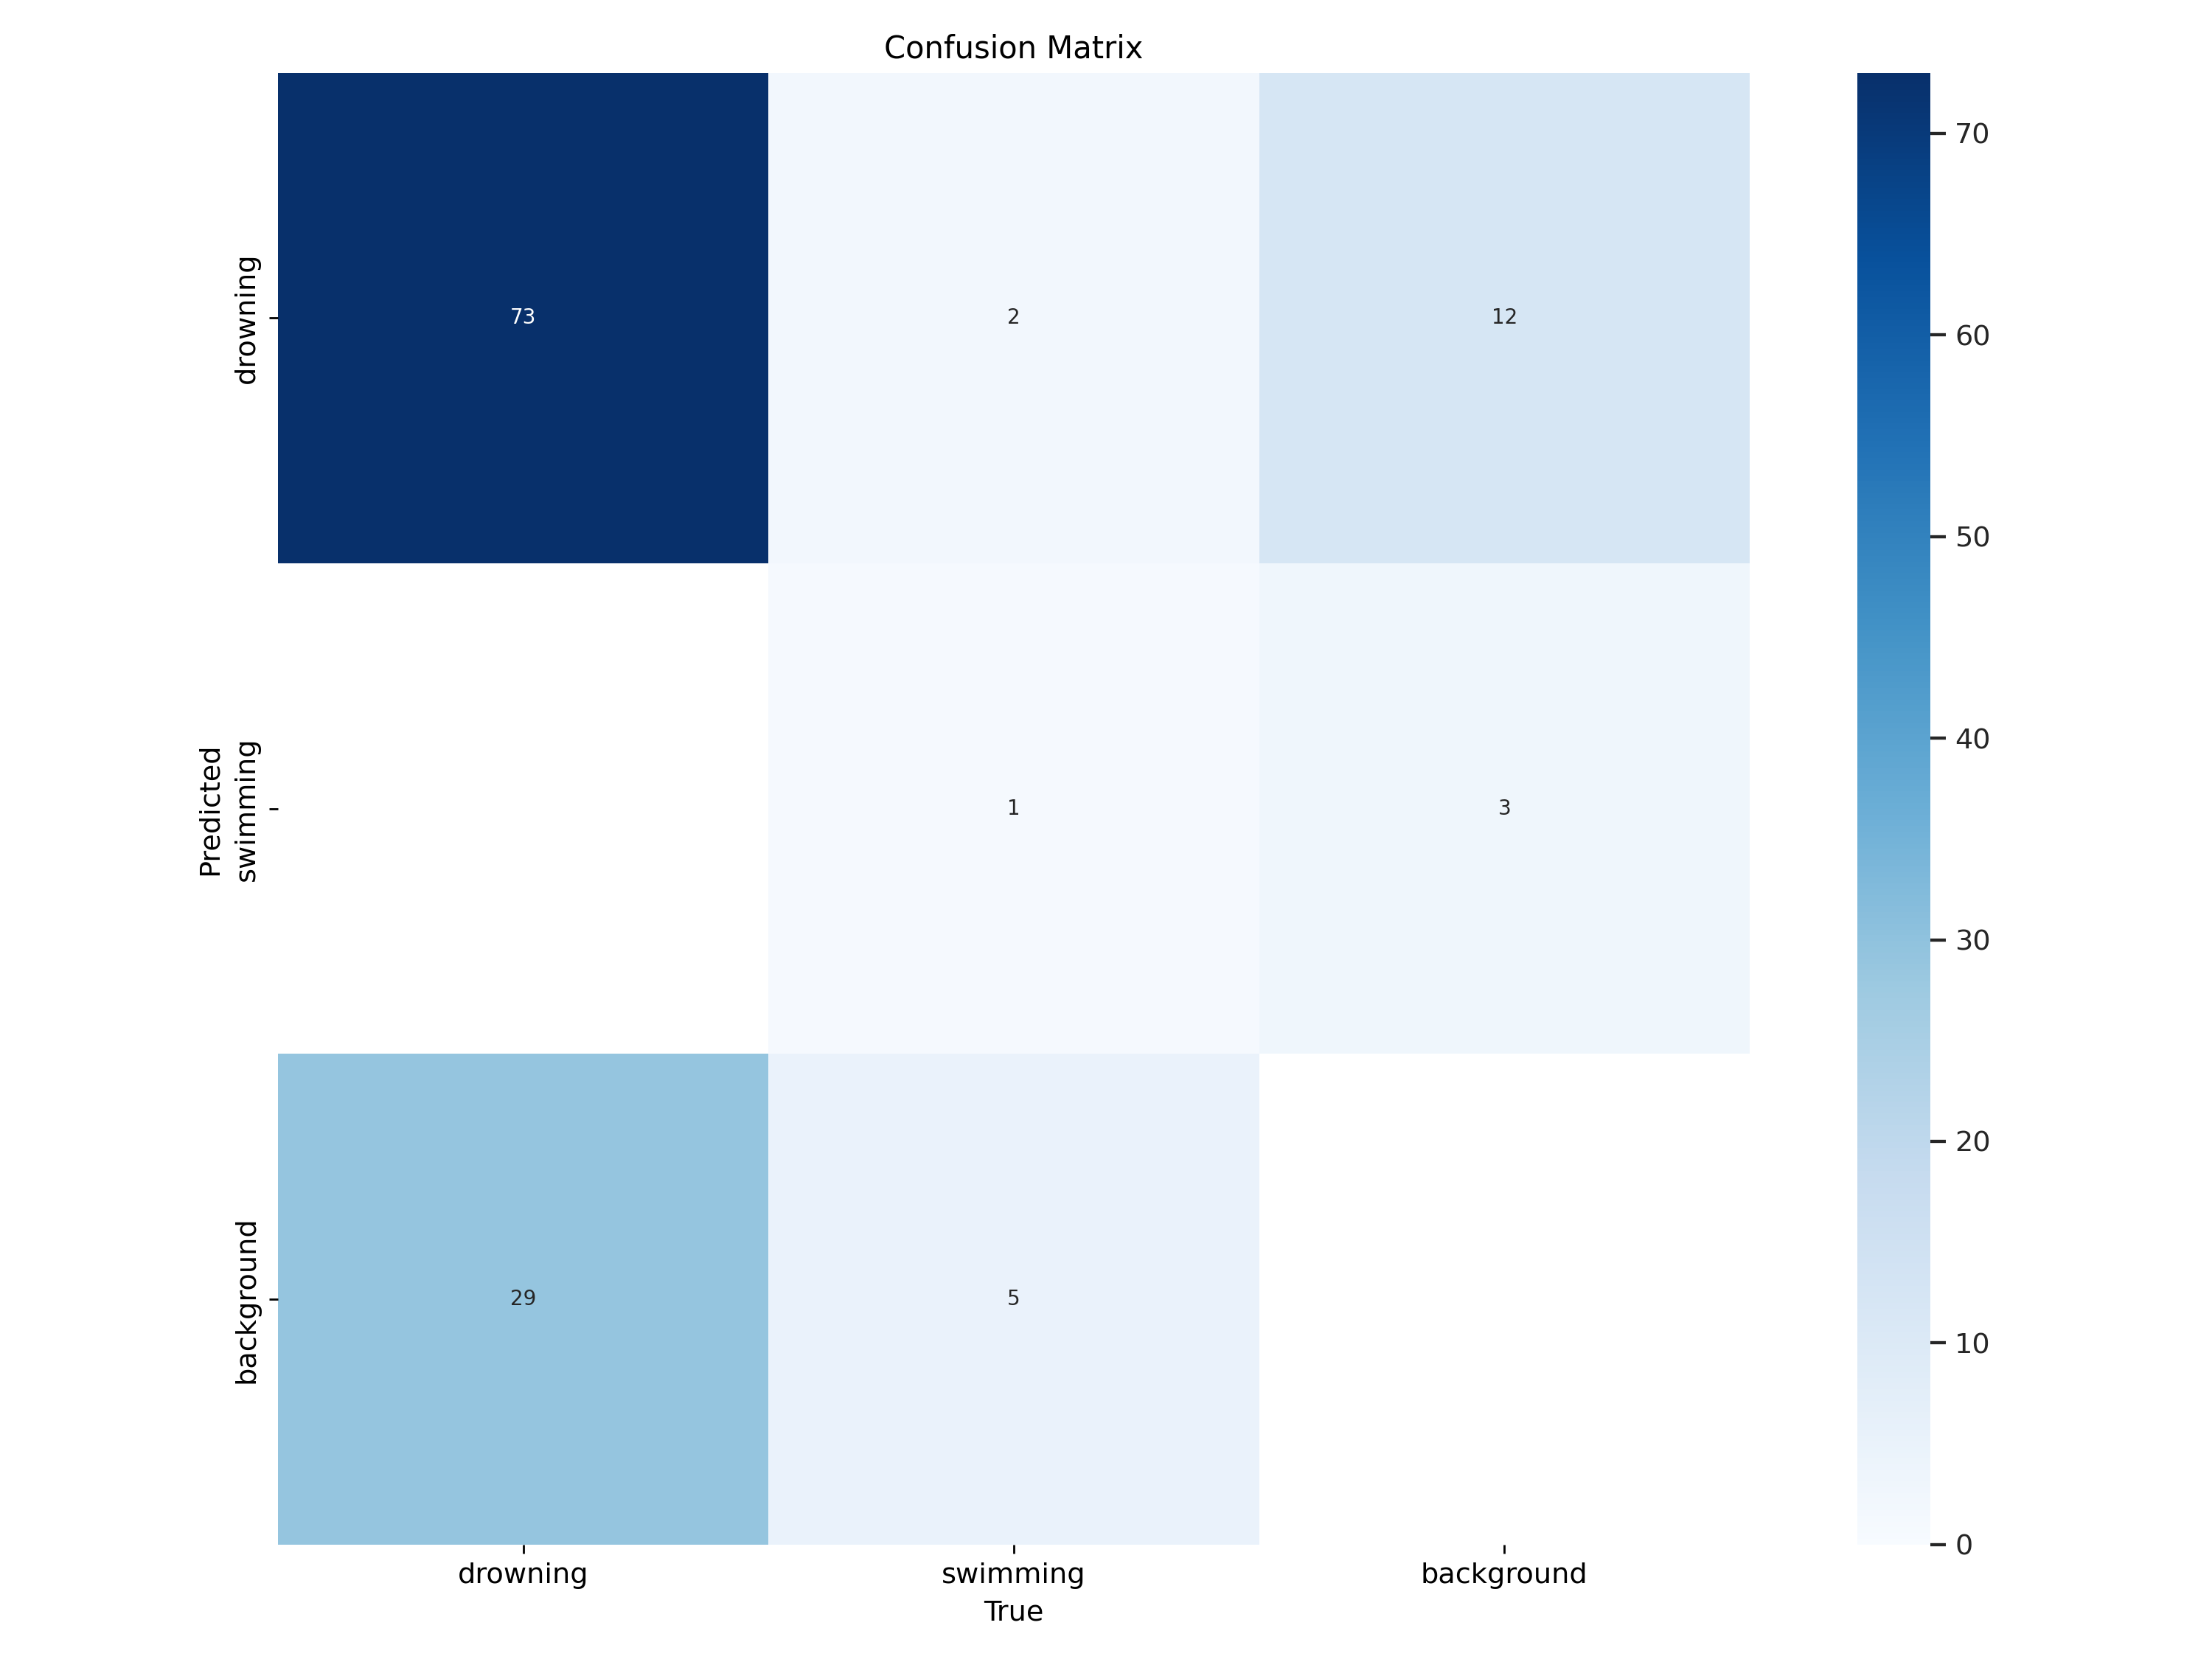

In [ ]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train3/confusion_matrix.png', width=1000)

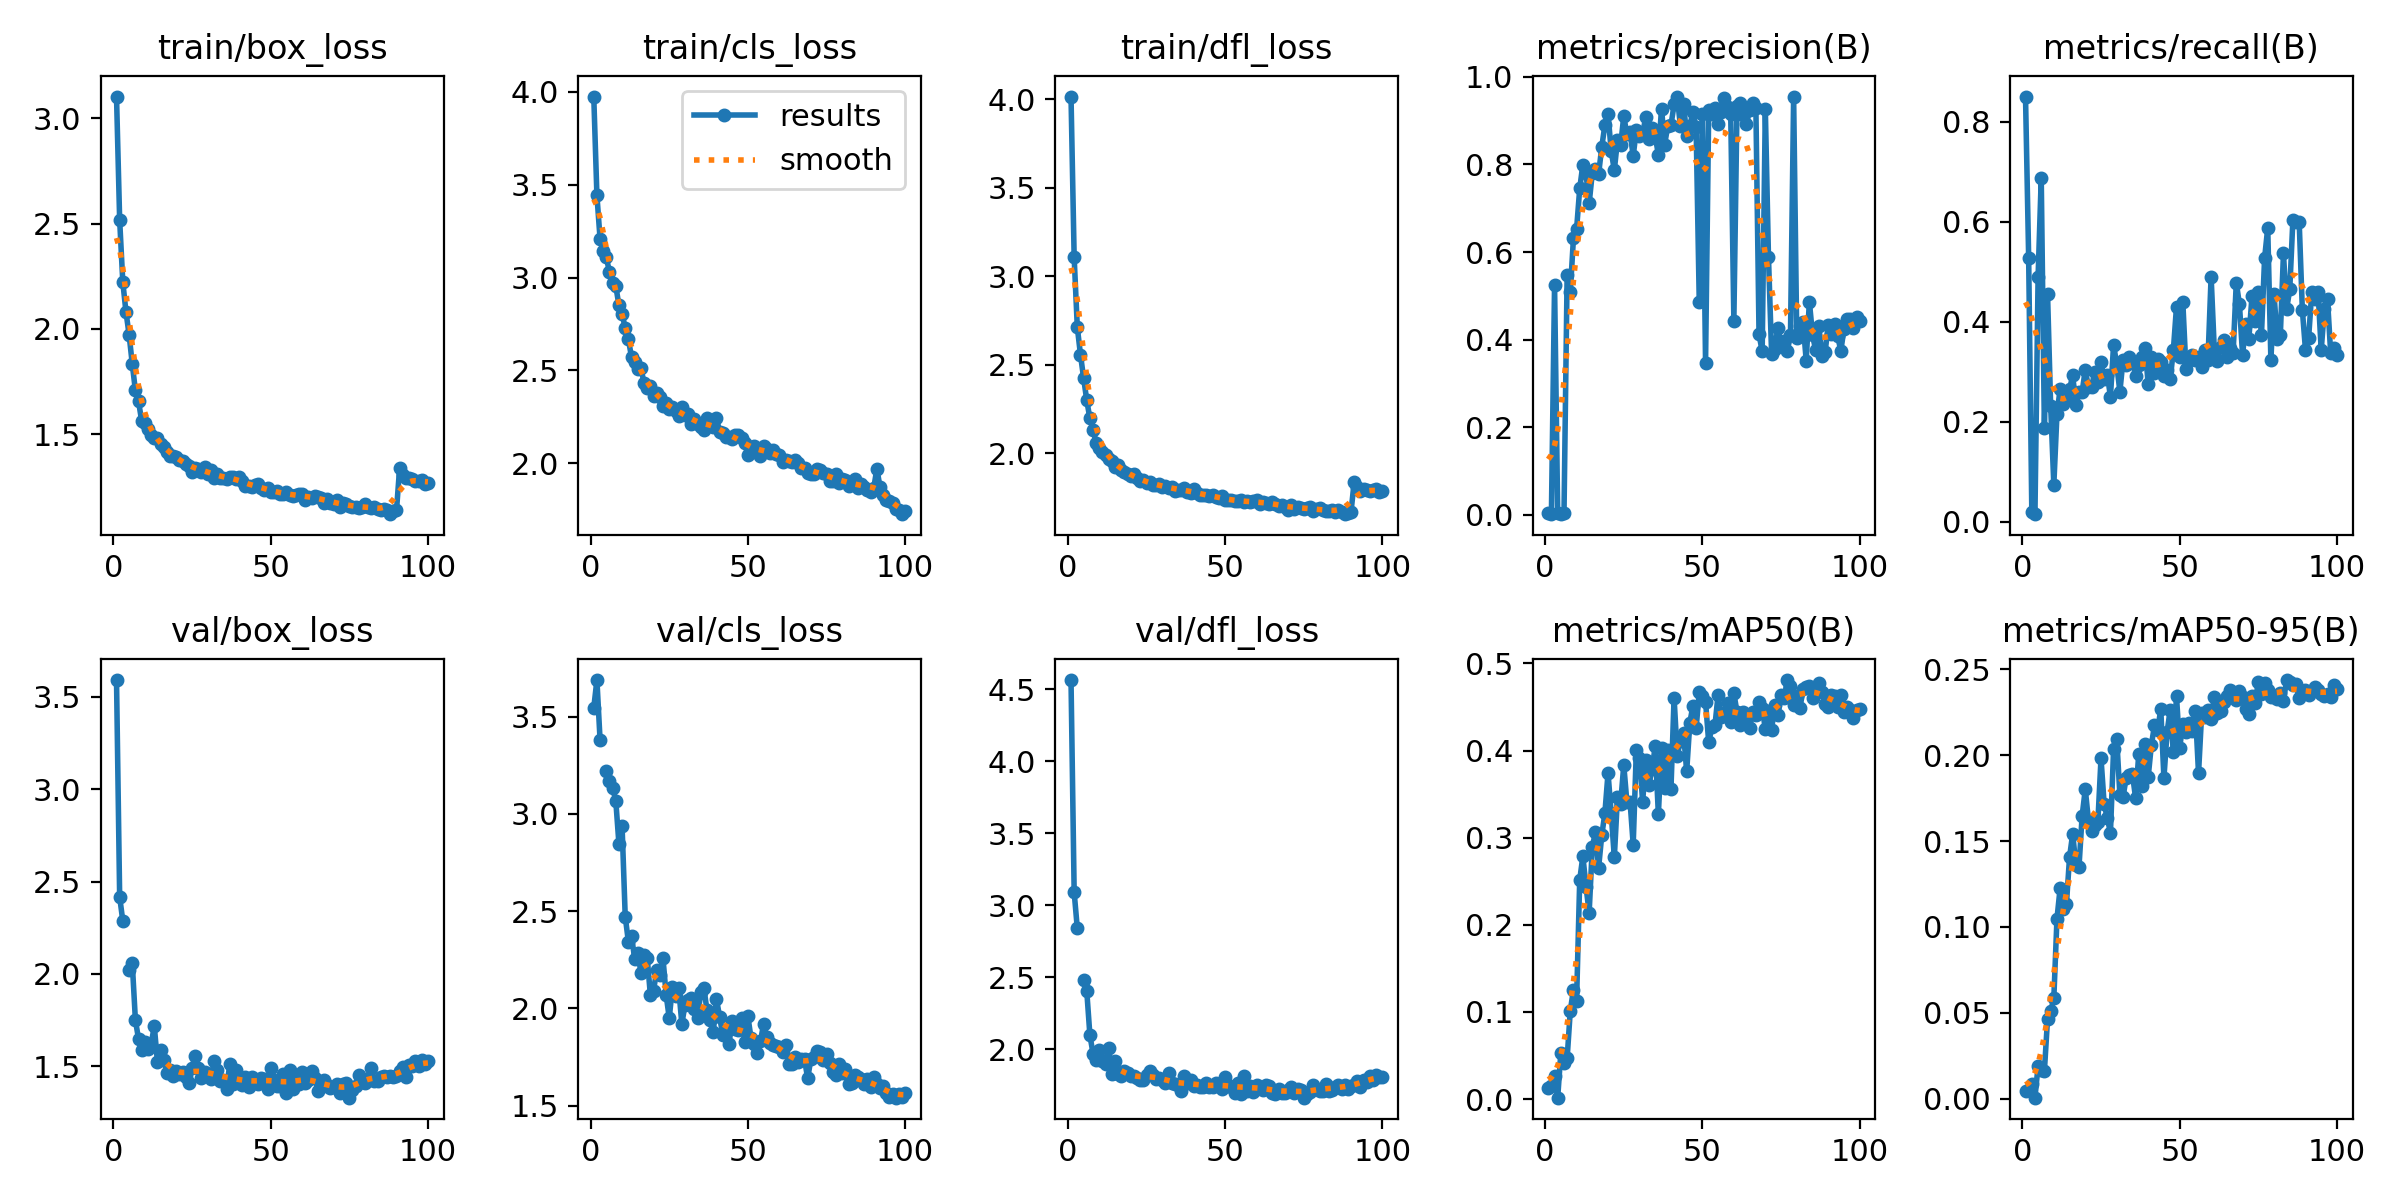

In [ ]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train3/results.png', width=1000)

In [ ]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['drowning', 'swimming']

In [ ]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train3/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [ ]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.27003290889575327
mAP 50 0.5771441347143187
mAP 75 0.22504003944889212


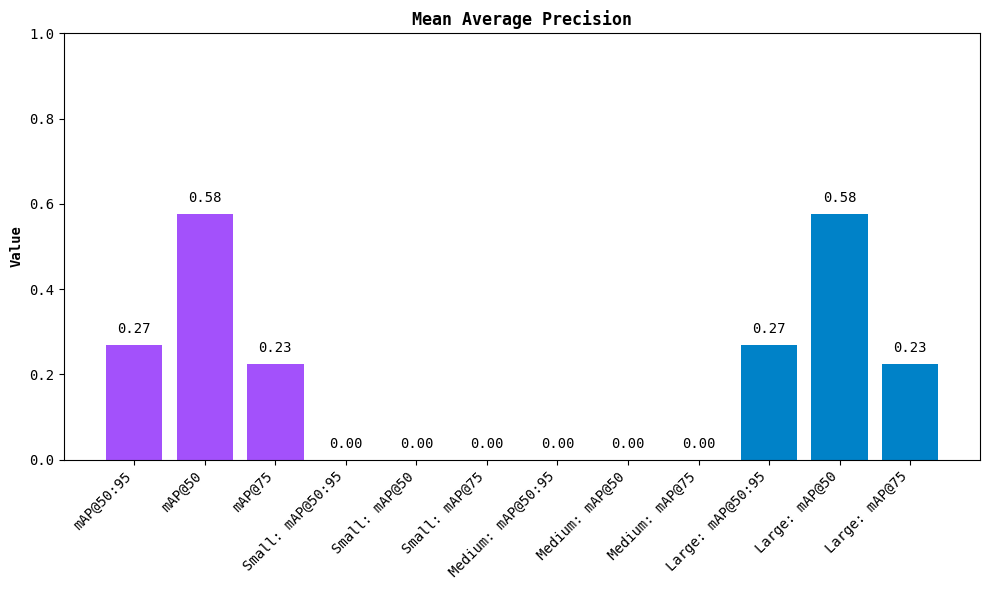

In [ ]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [30]:
import supervision as sv

model = YOLO(f'/{HOME}/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

In [25]:
from ultralytics import YOLO

model = YOLO('/content/best.pt')

results = model.predict("/content/D-PV-7-short.mp4", save=True)



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs



AttributeError: 'AAttn' object has no attribute 'qk'

In [22]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

AttributeError: 'AAttn' object has no attribute 'qk'